# Load review data

In [5]:
import pandas as pd

reviews = pd.read_csv("../data/tmp_reviews.csv", sep=",", index_col=False, encoding="utf-8")

In [6]:
import random
reviews = reviews.sample(n = 100)

# Define openAI function for sentiment chat completion
Constant
- model: gpt-4o
- max_tokens: 1
- temperature: 0

What to define in loop
- message: system + user/assistant prompts

Output: response as integer

In [7]:
# load and set API key for openAI

import openai
from openai import OpenAI

openai.api_key = open("C:/Users/munnes/Documents/API_Keys/openai_20240613.txt", "r").read()

client = OpenAI(api_key=openai.api_key)

In [8]:
def sentiment_analysis(message):

    # Call the OpenAI API to generate a response
    response = client.chat.completions.create(
        model="gpt-4o",  # Use a powerful model for sentiment analysis
        messages=message,
        max_tokens=1,  # Limit response to a single word
        temperature=0  # Keep response consistent
    )

    # Extract the sentiment from the response
    sentiment = response.choices[0].message.content
    sentiment = int(sentiment)

    return sentiment

# Create different prompts for different strategies (zeroshot, fewshot)

What to test:
- zeroshot or fewshot: no examples or examples (present as one text or user+assistant)
- examples (just fewshots): short or long (random ratings for fewshots for 3 or 4 classes times 1 or 2 reviews)
- system prompt: short or long (more detailed information and context)

Functions and objects:
- system_propmts: short and long
- random_rating: function to randomly sample examples -> reviews_examples_?
- test_strategies: dataframe to loop over with shots, examples, system
- create_fewshot_example: function to create fewshot prompts with examples
- create_message: function to combine system and fewshot prompt and add review text

In [9]:
# https://platform.openai.com/docs/guides/text-generation/chat-completions-api

system_short = "Du bist trainiert, die Qualität von deutschsprachigen Büchern aus kurzen Rezensionen zu extrahieren. Bewerte die Qualität des besprochenen Buches auf einer Skala von 1 (sehr schlecht) bis 7 (sehr gut). Antworte nur mit der Zahl."

system_long = "Du bist trainiert, die Qualität von deutschsprachigen Büchern aus kurzen Rezensionen zu extrahieren. Die Rezensionen enthalten oft auch kurze Zusammenfassungen des Inhalts, der für die Bewertung nicht wichtig ist. Fokussiere dich lediglich auf die verschiedenen Bewertungenmaßstäbe, gehe dabei systematisch vor und prüfe, welche Dimensionen der Buchqualität besprochen und bewertet werden. Bewerte die Qualität des besprochenen Buches auf einer Skala von 1 (sehr schlecht) bis 7 (sehr gut). Antworte nur mit der Zahl."

system_prompts = {"short": system_short, "long": system_long}

In [10]:
# function to randomly sample example reviews for different ratings
# input: dataframe; list of ratings, e.g. 1, 3, 5, 7; # of reviews per category
# output: dataframe with text (review) and rating (sent_hc_7) column; random order

def random_rating(df, ratings, n):

  revs_examples = pd.DataFrame(columns=['review', 'sent_hc_7'])

  for rating in ratings:
    revs = df[df["sent_hc_7"] == rating]
    revs = revs.sample(n=n)

    revs_examples = pd.concat([revs_examples, revs]) #, ignore_index=True

  revs_examples = revs_examples.sample(frac=1) #.reset_index(drop=True)
  
  revs_examples["sent_hc_7"] = revs_examples["sent_hc_7"].astype(str)
  
  return(revs_examples)

In [78]:
# create examples with different ratings and count for fewshot tests
reviews_examples_1 = random_rating(reviews, [1, 4, 7], 1)
reviews_examples_2 = random_rating(reviews, [1, 3, 5, 7], 2)

In [79]:
# drop reviews that are part of examples to avoid rating the same review by LLM (remove all examples, also for zeroshot)
reviews_noexamples = reviews.drop(index = reviews_examples_1.index.tolist() + reviews_examples_2.index.tolist())

In [80]:
import itertools

# Create a list of all possible combinations
combinations = list(itertools.product(
  ["zeroshot", "fewshot_1", "fewshot_2"],
  ["reviews_examples_1", "reviews_examples_2"],
  ["short", "long"]
  ))

test_strategies = pd.DataFrame(combinations, columns=['shots', 'examples', 'system'])

# test_strategies.query("shots == 'zeroshot' and examples == 'long'", inplace = True)
test_strategies = test_strategies.drop(test_strategies[(test_strategies['shots'] == 'zeroshot') & (test_strategies['examples'] == 'reviews_examples_2')].index)

In [81]:
def create_fewshot_example(fewshot, review_examples):
  """
  This function creates a fewshot example for the openAI API call.
  Returns a list of dictionaries containing the fewshot prompts. 
  Depends on input of prompting strategie (fewshot).
  Add single review text provided by loop.
  Raises a ValueError if non valid prompting strategy.
  """
  fewshot_text = []

  for index, row in review_examples.iterrows():

    if fewshot == "zeroshot": fewshot_text = []

    elif fewshot == "fewshot_1":
      sentence1 = f"Text: {row['review']}\n"
      sentence2 = f"Sentiment: {row['sent_hc_7']}\n"
      fewshot_text.append(sentence1 + sentence2)

    elif fewshot == "fewshot_2":
      fewshot_text.append({"role": "user", "content": row["review"]})
      fewshot_text.append({"role": "assistant", "content": row["sent_hc_7"]})

    else:
      raise ValueError("Invalid prompting strategy")

  if fewshot == "fewshot_1":
    fewshot_text = "".join(fewshot_text)

  return(fewshot_text)

In [48]:
def create_message(shot, system, review):
  """
  This function creates a message for the openAI API call.
  Returns a list of dictionaries containing system and user/assistant prompts. 
  Depends on input of prompting strategie (system and, zero/few-shots).
  Add single review text provided by loop.
  Raises a ValueError if non valid prompting strategy.
  """

  global system_prompts
  global fewshot

  message = [{"role": "system", "content": system_prompts[system]}]

  if shot == "zeroshot":
    message_zeroshot = {"role": "user", "content": review}
    message.append(message_zeroshot)
  elif shot == "fewshot_1":
    fewshot_1_tmp = fewshot + "\nText: " + review + "\nSentiment: "
    message.append({"role": "user", "content": fewshot_1_tmp})
  elif shot == "fewshot_2":
    message.extend(fewshot) #extend, bc fewshot_2 is list already
    message.append({"role": "user", "content": review})
  else:
    raise ValueError(f"Error: {shot} is not a valid prompting strategy title.")

  return message

# Call API: loop over system messages and shot-messages

In [93]:
sentiments = []

for index, row in test_strategies.iterrows():

  print(row["shots"], row["examples"], row["system"])

  fewshot = create_fewshot_example(row["shots"], globals()[row["examples"]])

  for index_rev, row_rev in reviews_noexamples.iterrows():

    print(index_rev)

    message = create_message(row["shots"], row["system"], row_rev["review"])

    sentiment = sentiment_analysis(message)

    sentiments.append([index_rev, sentiment, row["shots"], row["examples"], row["system"]])

zeroshot reviews_examples_1 short
4749
5823
2420
4964
3479
2855
4260
4081
5835
1970
2468
5725
3369
5430
85
2286
5419
2953
37
5821
2591
5225
2948
689
3932
1708
3979
3586
4054
1774
59
2087
2643
3358
4392
5480
5617
1693
1466
4130
2402
2507
77
884
1737
5548
5947
655
5589
5932
3712
33
922
2829
1507
1910
3680
5872
290
1933
4724
1688
2094
3615
528
341
1011
3553
4261
5518
1962
783
6005
2304
1864
933
2693
1334
3346
4995
509
1581
4216
3012
5056
4455
781
5433
5472
zeroshot reviews_examples_1 long
4749
5823
2420
4964
3479
2855
4260
4081
5835
1970
2468
5725
3369
5430
85
2286
5419
2953
37
5821
2591
5225
2948
689
3932
1708
3979
3586
4054
1774
59
2087
2643
3358
4392
5480
5617
1693
1466
4130
2402
2507
77
884
1737
5548
5947
655
5589
5932
3712
33
922
2829
1507
1910
3680
5872
290
1933
4724
1688
2094
3615
528
341
1011
3553
4261
5518
1962
783
6005
2304
1864
933
2693
1334
3346
4995
509
1581
4216
3012
5056
4455
781
5433
5472
fewshot_1 reviews_examples_1 short
4749
5823
2420
4964
3479
2855
4260
4081
5835
1970


In [75]:
sentiments = []

for system in ["short", "long"]:

    for shot in ["zeroshot", "fewshot_1", "fewshot_2"]:
        print(shot)

            for index, row in reviews_noexamples.iterrows():

                message = create_message(shot, system, row["review"])

                print(message)

                sentiment = sentiment_analysis(message)

                sentiments.append([index, sentiment, shot, system])


zeroshot
[{'role': 'system', 'content': 'Du bist trainiert, die Qualität von deutschsprachigen Büchern aus kurzen Rezensionen zu extrahieren. Bewerte die Qualität des besprochenen Buches auf einer Skala von 1 (sehr schlecht) bis 7 (sehr gut). Antworte nur mit der Zahle.'}, {'role': 'user', 'content': 'Den originellsten DDR-Roman der Saison hat ausgerechnet eine "Westschnepfe" geschrieben, so jedenfalls hätte es wohl Petra Morsbachs Protagonist formuliert, erklärt Alexander Cammann. In "Dichterliebe" erzählt die Autorin vom ehemals gefeierten Ost-Dichter Heinrich "Henry" Steiger, der mit seinem Bedeutungsverlust nach dem Mauerfall und mit der Einheit ganz allgemein nicht zurecht kommt, fasst der Rezensent zusammen. Er ist umgeben von "Ignoranten und Idioten", sein Verleger nervt ihn damit, dass er Prosa schreiben soll, Performance-Kunst kotzt ihn an und überhaupt: Ohne DDR ist alles doof. In einem ostfriesischen Künstlerhaus sitzt er ein Stipendium ab und quengelt über Vergangenheit und

In [76]:
column_names = ["index", "sentiment", "prompt", "prompt_system"]

sentiments_df = pd.DataFrame(sentiments, columns=column_names).set_index("index")

sentiments_df["rater"] = sentiments_df["prompt"] + "_" + sentiments_df["prompt_system"].apply(lambda x: str(len(x)))


In [80]:
sentiments_df_wide = sentiments_df.pivot(columns = "rater", values="sentiment") #["prompt", "prompt_system"]
sentiments_df_wide = sentiments_df_wide.join(reviews[:30])

In [86]:
import numpy as np

In [87]:
corr_matrix = sentiments_df_wide.select_dtypes(include=[np.number]).corr()

In [82]:
conda install seaborn

error: incomplete escape \U at position 28

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

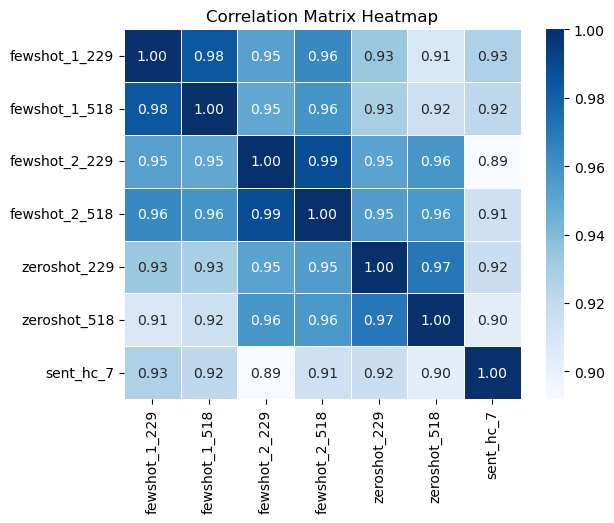

In [90]:
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='Blues', linewidths=0.5)

# Add title
plt.title("Correlation Matrix Heatmap")

# Show the plot
plt.show()

In [43]:
sentiments_zeroshot = []

for i, row in reviews.iterrows():
    # if i % 10 == 0: print(i)
    sentiment = sentiment_analysis(row["review"])
    sentiments_zeroshot.append(sentiment)

In [ ]:
reviews["sent_openai_zeroshot"] = sentiments_zeroshot

In [82]:
reviews_examples["review"][0]

'Einfach nur schrecklich findet Rezensentin Katharina Döbler Durs Grünbeins Poem zur Zerstörung Dresdens, für das er das Bild des Porzellans für ihren Geschmack reichlich überstrapaziert. "Schönheit und Zerbrechlichkeit, Hybris und Untergang" werden so unerbittlich zusammengereimt, dass die Rezensentin sich gelegentlich an die "Kalauer eines blödelnden Fernseh-Entainers" erinnert fühlt ("Von der bella ante bellum - nichts mehr da"). Meist aber sind ihr Bilder und Reimschema einfach zu bieder. Und das "altväterliche, offen patriarchalische Frauenbild" findet sie ebenfalls recht unzeitgemäß. Fragwürdig schließlich kommt ihr vor, was Grünbein daraus folgert, dass die Frauenkirche nach der Bombardierung noch einige Tage stand, bevor sie zusammenbrach: "so wie sie die Haltung wahren."'

In [76]:
sentiments_fewshots1 = []

for i, row in reviews.iterrows():
    print(i)
    sentiment = sentiment_analysis_fewshots(reviews_examples, row["review"])
    sentiments_fewshots1.append(sentiment)

2399
2455
5047
5250
3400
762
1441
3467
935
3781
2553
2984
5646
5130
5783
4582
2641
3884
4852
90
2014
5449
4912
1762
4784
5179
3140
2329
3316
1701
2796
5002
1325
3078
3184
5561
4658
3092
1733
3358


In [78]:
reviews["sent_openai_fewshot1"] = sentiments_fewshots1

In [111]:
reviews.to_csv("reviews_sentiment.csv")

In [ ]:
conda install -c conda-forge pingouin

In [108]:
revs_long = reviews[["sent_hc_7", "sent_openai_fewshot1"]].rename(columns={"sent_hc_7": "rating_human", "sent_openai_fewshot1": "rating_fewhot1"})

revs_long["id"] = revs_long.index

# Ensure the specific columns are of correct dtype.
revs_long['rating_human'] = revs_long['rating_human'].astype(str)
revs_long['rating_fewhot1'] = revs_long['rating_fewhot1'].astype(str)

revs_long = pd.wide_to_long(revs_long, stubnames=['rating'], i='id', j="rating", sep='_', suffix='.*', )

AttributeError: 'DataFrame' object has no attribute 'str'

In [77]:
conda install pingouin

error: incomplete escape \U at position 28

In [74]:
import pingouin as pg


icc = pg.intraclass_corr(data=sentiments_df, targets='index', raters='rater',
                         ratings='sentiment')

ModuleNotFoundError: No module named 'pingouin'